In [309]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import sklearn

In [310]:
# DATA
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

Tca = np.array(df['ahu_supply_temp']).reshape(-1,1)
Tsa = np.array(df['supply_discharge_temp']).reshape(-1,1)
qrh = np.array(df['htg_valve_position']).reshape(-1,1)

n_train = 256

Tca_k1 = Tca[1:n_train+1]
Tsa_k  = Tsa[0:n_train]
Tsa_k1 = Tsa[1:n_train+1]
qrh_k2 = qrh[2:n_train+2]
ones   = np.ones((n_train,1))

y      = Tsa[2:n_train+2]

x0     = np.copy(Tca_k1)
x1     = np.copy(Tsa_k)
x2     = np.copy(Tsa_k1)
x3     = np.copy(qrh_k2)

x02    = x0**2
x12    = x1**2
x22    = x2**2
x32    = x3**2
x0x1   = x0*x1
x0x2   = x0*x2
x0x3   = x0*x3
x1x2   = x1*x2
x1x3   = x1*x3
x2x3   = x2*x3

x0_t = Tca[n_train+1:-1]
x1_t = Tsa[n_train:-2]
x2_t = Tsa[n_train+1:-1]
x3_t = qrh[n_train+2:]
y_t  = Tsa[n_train+2:]
ones_t = np.ones((Tca.shape[0]-n_train-2, 1))

A = np.concatenate((ones, x0, x1, x2, x3, x02, x12, x22, x32, x0x1, x0x2, x0x3, x1x2, x1x3, x2x3), axis=1)
b = np.copy(y)

In [311]:
# SINDy with STLS
alpha = 0.01
para = ()
A1 = np.copy(A)
while(1):
    c = np.linalg.lstsq(A1, b, rcond=-1)[0]
    c = c*(np.abs(c)>alpha)
    para = para + (c,)

    cols = np.array([], dtype=np.int32)
    for i in range(c.shape[0]):
        if c[i] == 0:
            cols = np.append(cols, i)
    if(cols.shape[0] == 0): break
    A1 = np.delete(A1, cols, axis=1)

In [312]:
# STLS
def transfer(long, short):
    cols = np.where(long != 0)[0]
    out = np.copy(long)
    for i, c in enumerate(cols):
        out[c] = short[i]
    return out

def convert(para):
    c = para[len(para)-1]
    for i in range(len(para)-1):
        c = transfer(para[len(para) - 2 - i], c)
    return c

c = convert(para)
print("Number of terms:", np.sum((c!=0)))

Number of terms: 11


In [313]:
# System
def system(one, x0, x1, x2, x3):
    return c[0]*one + c[1]*x0 + c[2]*x1 + c[3]*x2 + c[4]*x3 + \
           c[5]*x0**2 + c[6]*x1**2 + c[7]*x2**2 + c[8]*x3**2 + c[9]*x0*x1 + c[10]*x0*x2 + c[11]*x0*x3 + c[12]*x1*x2 + c[13]*x1*x3 + c[14]*x2*x3

RMSE: 1.5333142783091656
R2:   0.9772400067637873


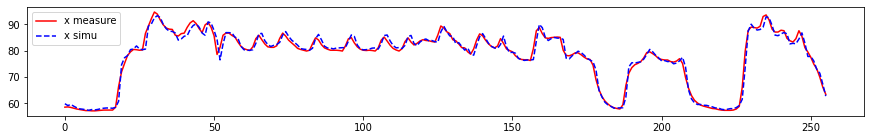

In [314]:
x_simu = system(ones, x0, x1, x2, x3)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y))))
print("R2:  ", sklearn.metrics.r2_score(y, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y,      'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()

RMSE: 1.4647049332431847
R2:   0.9866233943046296


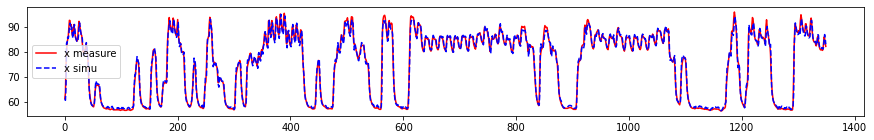

In [315]:
x_simu = system(ones_t, x0_t, x1_t, x2_t, x3_t)
print("RMSE:", np.sqrt(np.mean(np.square(x_simu - y_t))))
print("R2:  ", sklearn.metrics.r2_score(y_t, x_simu))

# plot
plt.figure(figsize=(15,2))
plt.plot(y_t,    'r-',  label='x measure')
plt.plot(x_simu, 'b--', label='x simu')
plt.legend()
plt.show()